In [5]:
!pip install scipy

In [96]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import scipy 
import os
from datetime import date, datetime
plt.rcParams["figure.figsize"] = (18, 12) # (w, h)
plt.gcf().autofmt_xdate(rotation=90)

<Figure size 1800x1200 with 0 Axes>

In [119]:
def filename(notboookname, filename):
  notebook_path = os.path.abspath(f"{notboookname}.ipynb")
  return os.path.join(os.path.dirname(notebook_path), '..', 'data', filename)

symbol    = 'esea'
csv_file  = filename('hawkes', f"{symbol}-1h.csv")
print(csv_file)
data      = pd.read_csv(csv_file,
                        parse_dates=[0],
                        index_col=[0],
                        date_parser=lambda x: pd.to_datetime(x, utc=True))

In [105]:
def plot_two_axes(series1, *ex_series):
    ax  = series1.plot(color='green')
    ax2 = ax.twinx()
    for i, series in enumerate(ex_series):
        series.plot(ax=ax2, alpha=0.5)
    plt.style.use('dark_background')
    plt.xticks(rotation=90)
    plt.gcf().autofmt_xdate()
    plt.show()

def hawkes_process(data: pd.Series, kappa: float):
    assert(kappa > 0.0)
    alpha = np.exp(-kappa)
    arr = data.to_numpy()
    output = np.zeros(len(data))
    output[:] = np.nan
    for i in range(1, len(data)):
        if np.isnan(output[i - 1]):
            output[i] = arr[i]
        else:
            output[i] = output[i - 1] * alpha + arr[i]
    return pd.Series(output, index=data.index) * kappa

def vol_signal(close: pd.Series, vol_hawkes: pd.Series, lookback:int):
    signal = np.zeros(len(close))
    q05 = vol_hawkes.rolling(lookback).quantile(0.05)
    q95 = vol_hawkes.rolling(lookback).quantile(0.95)
    
    last_below = -1
    curr_sig = 0

    for i in range(len(signal)):
        if vol_hawkes.iloc[i] < q05.iloc[i]:
            last_below = i
            curr_sig = 0

        if vol_hawkes.iloc[i] > q95.iloc[i] \
           and vol_hawkes.iloc[i - 1] <= q95.iloc[i - 1] \
           and last_below > 0 :
            
            change = close.iloc[i] - close.iloc[last_below]
            if change > 0.0:
                curr_sig = 1
            else:
                curr_sig = -1
        signal[i] = curr_sig

    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['Close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades

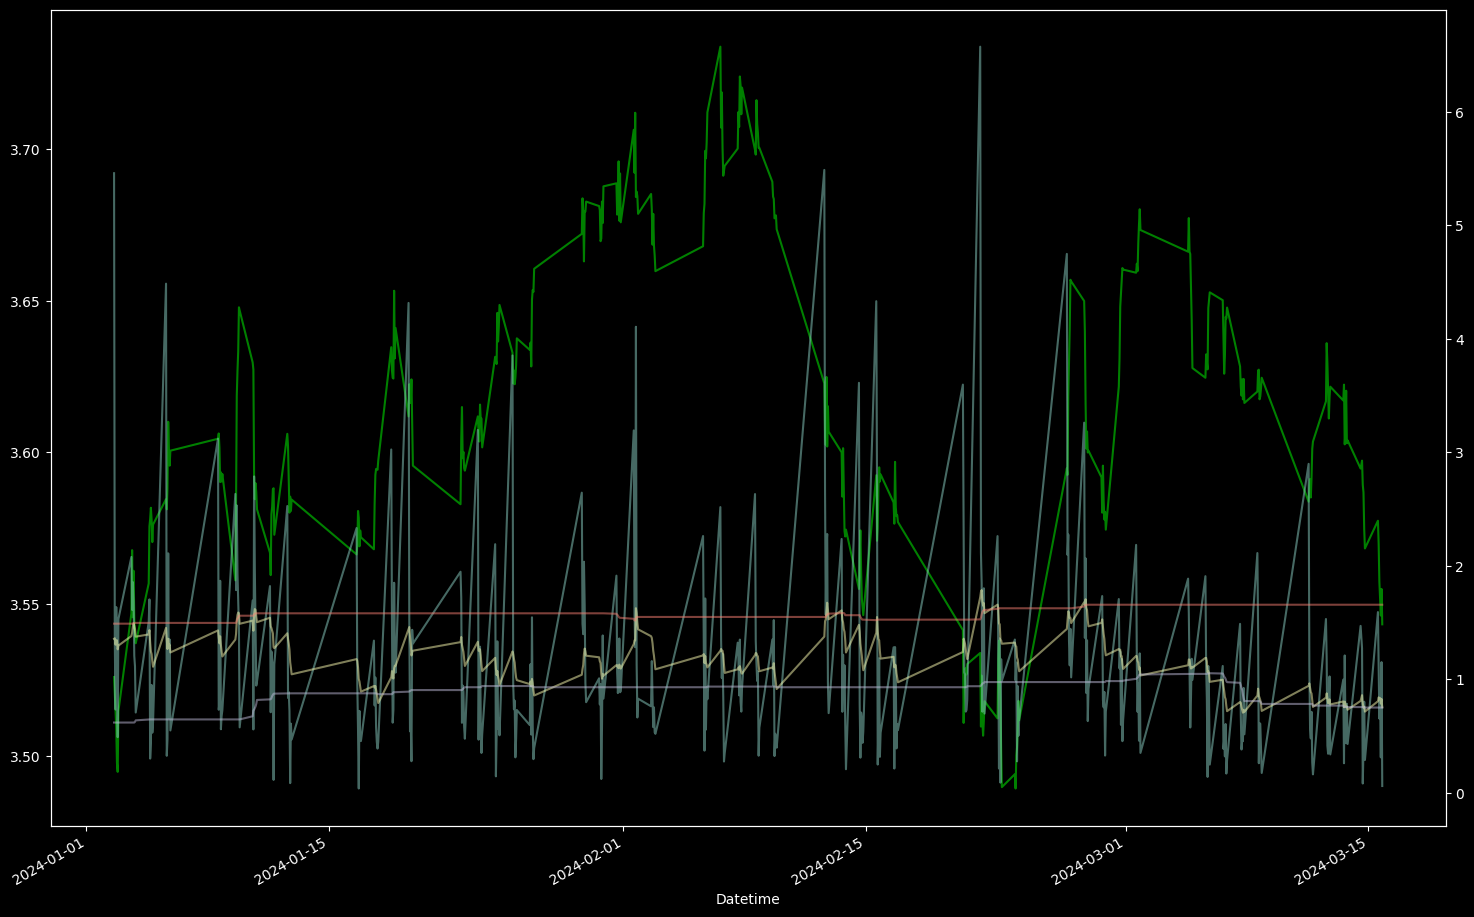

<AxesSubplot: xlabel='Datetime'>

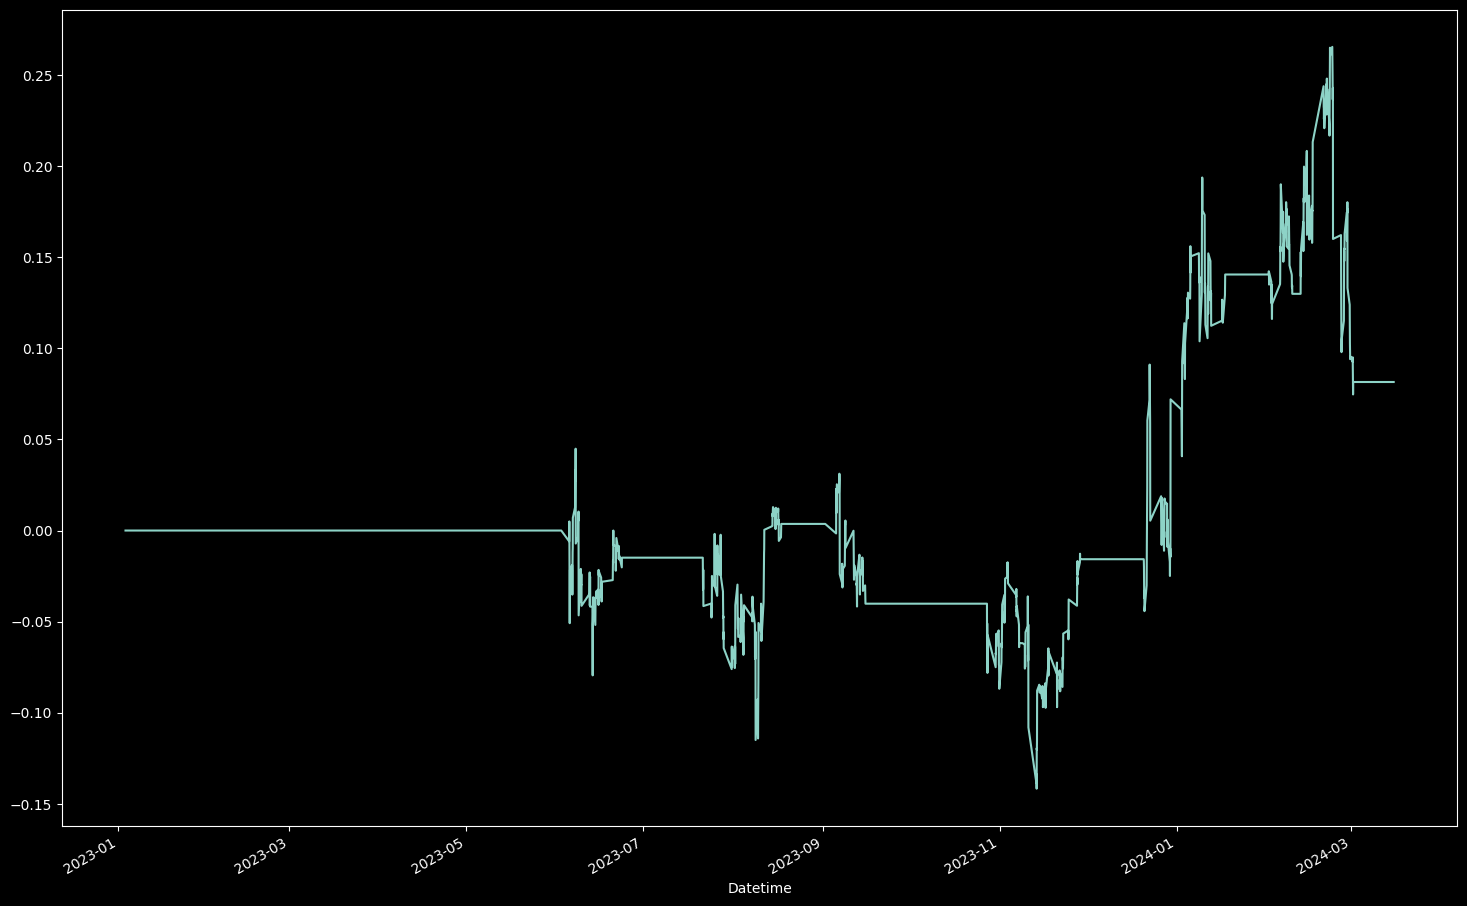

In [113]:
# Normalize volume
norm_lookback         = 336
data['atr']           = ta.atr(np.log(data['High']), np.log(data['Low']), np.log(data['Close']), norm_lookback) 
data['norm_range']    = (np.log(data['High']) - np.log(data['Low'])) / data['atr']

data['v_hawk']        = hawkes_process(data['norm_range'], 0.1)
data['sig']           = vol_signal(data['Close'], data['v_hawk'], 168)

data['next_return']   = np.log(data['Close']).diff().shift(-1)
data['signal_return'] = data['sig'] * data['next_return']


date_from             = datetime.strptime('2024-01-01', '%Y-%m-%d')
date_from             = pd.Timestamp(date_from, unit='ms')
date_from             = date_from.tz_localize('utc')

q05                   = data['v_hawk'].rolling(168).quantile(0.05)
q95                   = data['v_hawk'].rolling(168).quantile(0.95)

filtered_df           = data[data.index > date_from]
filtered_q05          = q05[q05.index > date_from]
filtered_q95          = q95[q95.index > date_from]
plot_two_axes(np.log(filtered_df['Close']), filtered_df['norm_range'], filtered_df['v_hawk'], filtered_q05, filtered_q95)

win_returns           = data[data['signal_return'] > 0]['signal_return'].sum()
lose_returns          = data[data['signal_return'] < 0]['signal_return'].abs().sum()
signal_pf             = win_returns / lose_returns

data['signal_return'].cumsum().plot()

In [114]:
long_trades, short_trades = get_trades_from_signal(data, data['sig'].to_numpy())
long_win_rate = len(long_trades[long_trades['percent'] > 0]) / len(long_trades)
short_win_rate = len(short_trades[short_trades['percent'] > 0]) / len(short_trades)
long_average = long_trades['percent'].mean()
short_average = short_trades['percent'].mean()
time_in_market = len(data[data['sig'] != 0.0]) / len(data)

print("Profit Factor", signal_pf)
print("Long Win Rate", long_win_rate) 
print("Long Average", long_average) 
print("Short Win Rate", short_win_rate) 
print("Short Average", short_average)
print("Time In Market", time_in_market)




Profit Factor 1.0278744027323448
Long Win Rate 0.42857142857142855
Long Average 0.044447742240200046
Short Win Rate 0.0
Short Average -0.07002896437536987
Time In Market 0.3291015625


Text(195.72222222222223, 0.5, 'Threshold Lookback')

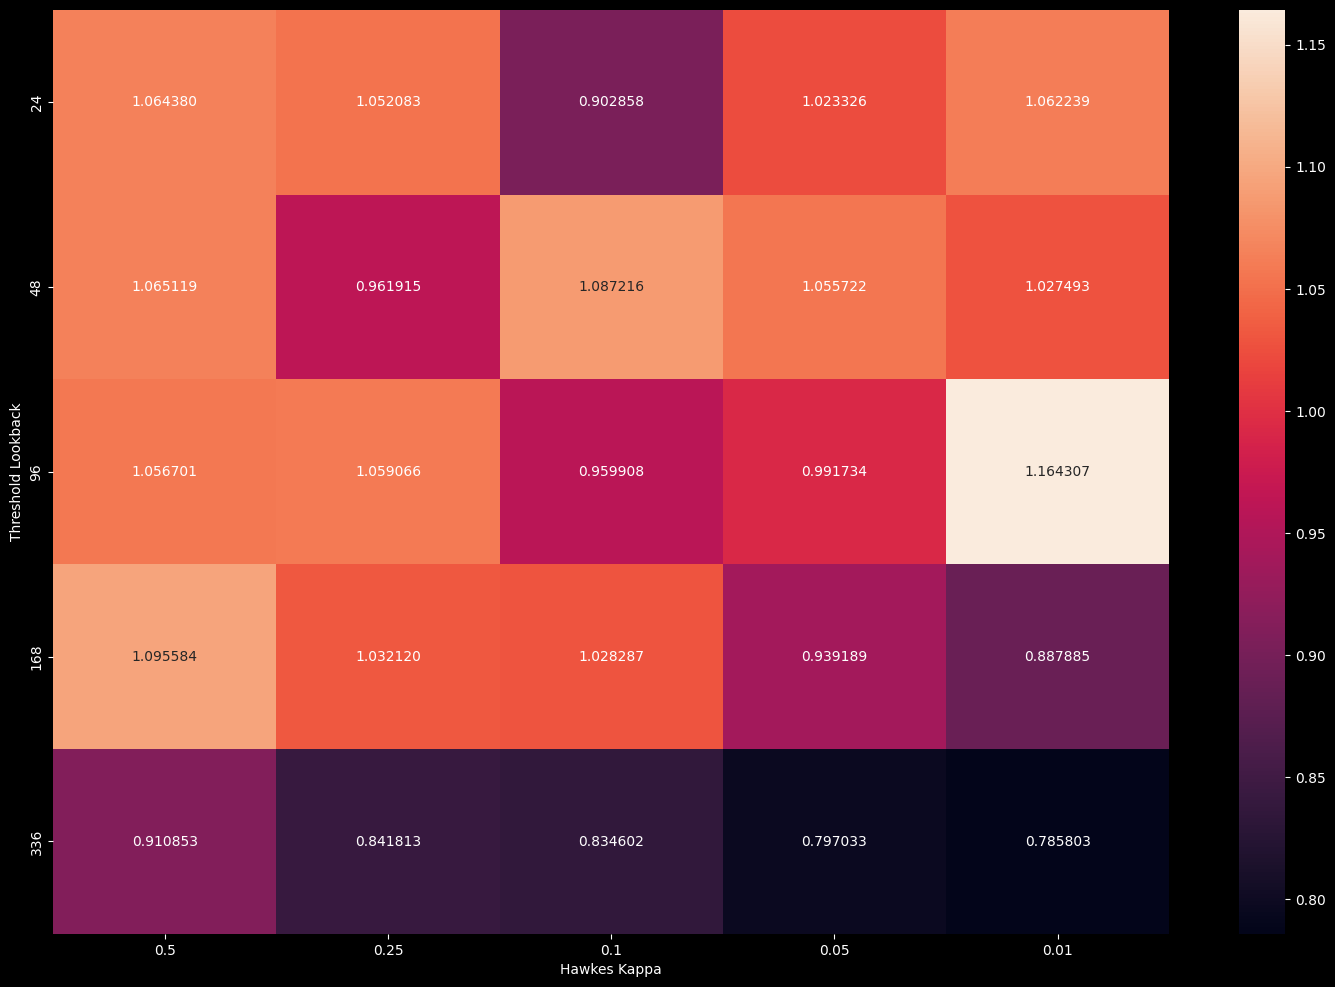

In [112]:
# Code for the heatmap
kappa_vals = [0.5, 0.25, 0.1, 0.05, 0.01]
lookback_vals = [24, 48, 96, 168, 336] 
pf_df = pd.DataFrame(index=lookback_vals, columns=kappa_vals)

for lb in lookback_vals:
    for k in kappa_vals:
        data['v_hawk'] = hawkes_process(data['norm_range'], k)
        data['sig'] = vol_signal(data['Close'], data['v_hawk'], lb)

        data['next_return'] = np.log(data['Close']).diff().shift(-1)
        data['signal_return'] = data['sig'] * data['next_return']
        win_returns = data[data['signal_return'] > 0]['signal_return'].sum()
        lose_returns = data[data['signal_return'] < 0]['signal_return'].abs().sum()
        signal_pf = win_returns / lose_returns

        pf_df.loc[lb, k] = float(signal_pf)
    
plt.style.use('dark_background')
import seaborn as sns
pf_df = pf_df.astype(float)
sns.heatmap(pf_df, annot=True, fmt='f')
plt.xlabel('Hawkes Kappa')
plt.ylabel('Threshold Lookback')
